# **Bioinformatics Project - Computational Ames test [Part 2] Exploratory Data Analysis**

Marc Jermann

In this Jupyter notebook, we will be building a real-life **data science project**. Particularly, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

---

## **Install conda and rdkit** and login to gdrive

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## **Load bioactivity data**

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/bioactivity_preprocessed_data.csv')
df

,molecule_chembl_id,canonical_smiles,activity_comment
0,CHEMBL398372,CC(C)(N)C(=O)N[C@H](COCc1ccccc1)c1nnnn1CCOC(=O...,Non-toxic
1,CHEMBL137803,C=C1C(=O)O[C@@H]2C[C@@]3(C)CCCC(=C)[C@@H]3C[C@...,Toxic
2,CHEMBL486423,C=C1CCC[C@]2(C)C[C@H]3OC(=O)[C@@H](C)[C@H]3C[C...,Non-toxic
3,CHEMBL6466,O=c1ccc2ccccc2o1,Non-toxic
4,CHEMBL24171,COc1c2ccoc2cc2oc(=O)ccc12,Non-toxic
...,...,...,...
650,CHEMBL4283853,COCCCOc1cc2c(cc1OC)-c1cc(=O)c(C(=O)O)cn1[C@H](...,Non-toxic
651,CHEMBL4284040,N#C/C(=C\c1cccc2cnccc12)c1c[nH]c2ccccc12,Non-toxic
652,CHEMBL3945880,O=c1cc(NC2CCN(S(=O)(=O)C(F)(F)F)CC2)c2cc(C(c3c...,Non-toxic
653,CHEMBL4514379,N#Cc1cnc2ccc(-c3c(-c4ccc(F)c(Cl)c4)ncn3CCO)nn12,Non-toxic


In [ ]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [ ]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,activity_comment,canonical_smiles
0,CHEMBL398372,Non-toxic,CC(C)(N)C(=O)N[C@H](COCc1ccccc1)c1nnnn1CCOC(=O...
1,CHEMBL137803,Toxic,C=C1C(=O)O[C@@H]2C[C@@]3(C)CCCC(=C)[C@@H]3C[C@...
2,CHEMBL486423,Non-toxic,C=C1CCC[C@]2(C)C[C@H]3OC(=O)[C@@H](C)[C@H]3C[C...
3,CHEMBL6466,Non-toxic,O=c1ccc2ccccc2o1
4,CHEMBL24171,Non-toxic,COc1c2ccoc2cc2oc(=O)ccc12
...,...,...,...
650,CHEMBL4283853,Non-toxic,COCCCOc1cc2c(cc1OC)-c1cc(=O)c(C(=O)O)cn1[C@H](...
651,CHEMBL4284040,Non-toxic,N#C/C(=C\c1cccc2cnccc12)c1c[nH]c2ccccc12
652,CHEMBL3945880,Non-toxic,O=c1cc(NC2CCN(S(=O)(=O)C(F)(F)F)CC2)c2cc(C(c3c...
653,CHEMBL4514379,Non-toxic,N#Cc1cnc2ccc(-c3c(-c4ccc(F)c(Cl)c4)ncn3CCO)nn12


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **Import libraries**

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,463.539,0.28320,4.0,10.0
1,232.323,3.24060,0.0,2.0
2,234.339,3.32050,0.0,2.0
3,146.145,1.79300,0.0,2.0
4,216.192,2.54780,0.0,4.0
...,...,...,...,...
650,401.459,3.39060,1.0,6.0
651,295.345,4.78028,1.0,2.0
652,610.485,6.74100,2.0,4.0
653,382.786,2.91628,1.0,7.0


### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [ ]:
df_final = pd.concat([df,df_lipinski], axis=1)

In [ ]:
df_final = df_final.rename(columns={"activity_comment": "class"})

In [ ]:
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL398372,CC(C)(N)C(=O)N[C@H](COCc1ccccc1)c1nnnn1CCOC(=O...,Non-toxic,463.539,0.28320,4.0,10.0
1,CHEMBL137803,C=C1C(=O)O[C@@H]2C[C@@]3(C)CCCC(=C)[C@@H]3C[C@...,Toxic,232.323,3.24060,0.0,2.0
2,CHEMBL486423,C=C1CCC[C@]2(C)C[C@H]3OC(=O)[C@@H](C)[C@H]3C[C...,Non-toxic,234.339,3.32050,0.0,2.0
3,CHEMBL6466,O=c1ccc2ccccc2o1,Non-toxic,146.145,1.79300,0.0,2.0
4,CHEMBL24171,COc1c2ccoc2cc2oc(=O)ccc12,Non-toxic,216.192,2.54780,0.0,4.0
...,...,...,...,...,...,...,...
650,CHEMBL4283853,COCCCOc1cc2c(cc1OC)-c1cc(=O)c(C(=O)O)cn1[C@H](...,Non-toxic,401.459,3.39060,1.0,6.0
651,CHEMBL4284040,N#C/C(=C\c1cccc2cnccc12)c1c[nH]c2ccccc12,Non-toxic,295.345,4.78028,1.0,2.0
652,CHEMBL3945880,O=c1cc(NC2CCN(S(=O)(=O)C(F)(F)F)CC2)c2cc(C(c3c...,Non-toxic,610.485,6.74100,2.0,4.0
653,CHEMBL4514379,N#Cc1cnc2ccc(-c3c(-c4ccc(F)c(Cl)c4)ncn3CCO)nn12,Non-toxic,382.786,2.91628,1.0,7.0


Let's write this to CSV file.

In [ ]:
df_final.to_csv('ames-test_bioactivity_data.csv')

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

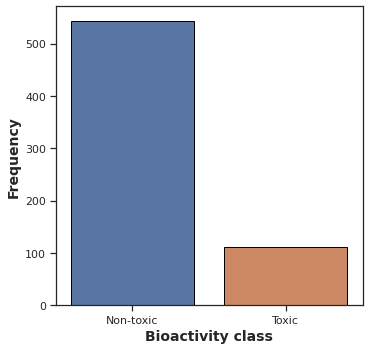

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_final, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

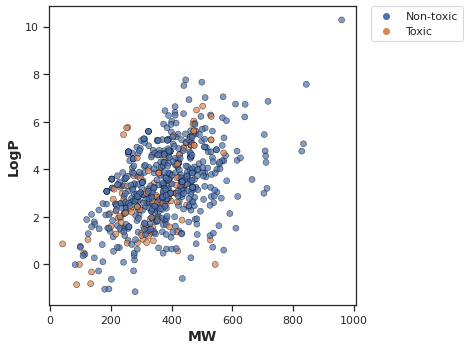

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final, hue='class', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_final[selection]
  active = df[df['class'] == 'Toxic']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_final[selection]
  inactive = df[df['class'] == 'Non-toxic']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

#### **MW**

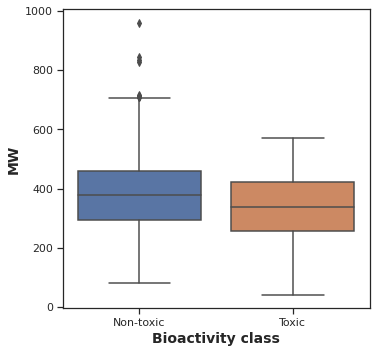

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,25065.0,0.002389,0.05,Different distribution (reject H0)


#### **LogP**

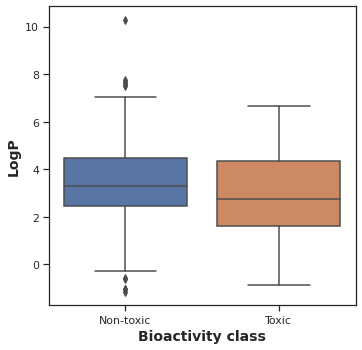

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,25450.5,0.004534,0.05,Different distribution (reject H0)


#### **NumHDonors**

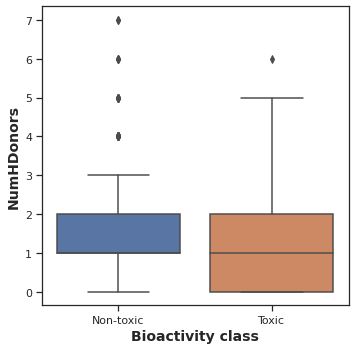

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,26673.0,0.021797,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

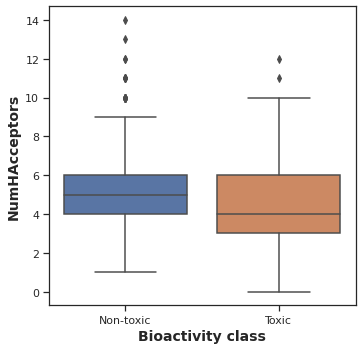

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,27203.0,0.048219,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.

## **Zip files**

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

updating: plot_NumHDonors.pdf (deflated 38%)
updating: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
updating: plot_MW.pdf (deflated 40%)
updating: mannwhitneyu_LogP.csv (deflated 10%)
updating: mannwhitneyu_NumHDonors.csv (deflated 10%)
updating: mannwhitneyu_MW.csv (deflated 9%)
updating: plot_NumHAcceptors.pdf (deflated 38%)
updating: plot_bioactivity_class.pdf (deflated 39%)
updating: ames-test_bioactivity_data.csv (deflated 73%)
updating: plot_MW_vs_LogP.pdf (deflated 21%)
updating: plot_LogP.pdf (deflated 39%)


In [ ]:
! cp ames-test_bioactivity_data.csv "/content/gdrive/My Drive/Colab Notebooks/data"